## Gaussian Localization -- Condensed

In [123]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


In [133]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

### Forward model parameters
Filter mask, PSF

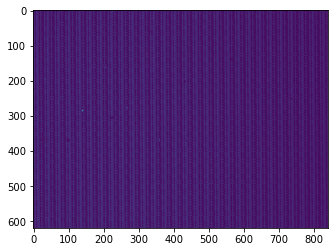

Shape of the filter array: torch.Size([620, 840, 45])


In [134]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


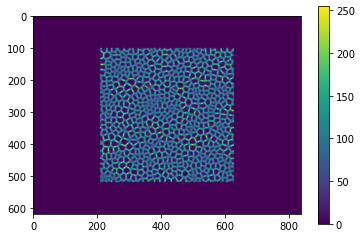

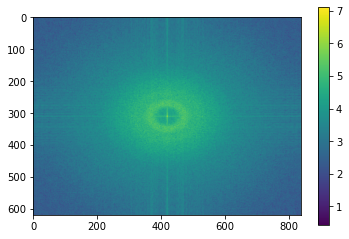

In [135]:
# PSF

datafolder = '../Calibration_Data'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

### Construct ground truth gaussian object

In [136]:
# Ground truth parameters -- must be floats
muy = 50.0
mux = 150.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

In [137]:
# Create gaussian object and 3D array
g_ground = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d = g_ground.createPixelGauss(NY,NX,NL)

### Get ground truth measurement

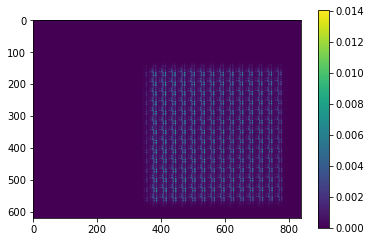

In [139]:
# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_padded = sdc.pad(g3d.detach())

# Get measurement
gt_measurement = sdc.forwardmodel3d(g3d_padded, hf_padded_3d, m)
gt_measurement = gt_measurement/torch.norm(gt_measurement) # normalize
plt.figure()
plt.imshow(gt_measurement.detach().numpy())
plt.colorbar()
plt.show() 

### Initialize random gaussian guess

In [148]:
# Define a Gaussian object with initialized values

# Initialized guess parameters -- must be floats
muy_init = 10.
mux_init = 10.
mul_init = 0.
sigy_init = 10.
sigx_init = 10.
sigl_init = 1.
lr_init = 0.01
NY, NX, NL = m.shape

g_init = gp.GaussObject(muy_init,mux_init,mul_init,sigy_init,sigx_init,sigl_init,learningrate=lr_init)

gaussObject(mu_x = 10.0, mu_y = 10.0, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)


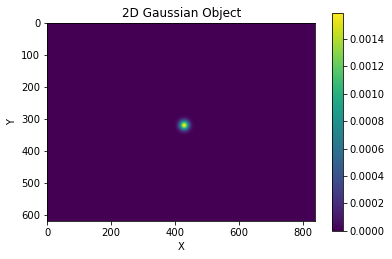

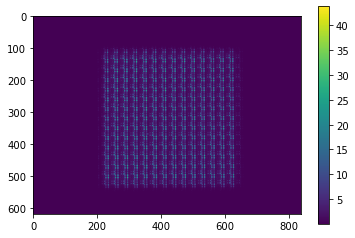

In [149]:
# Display the initial Gaussian guess and its measurement

# Object
print(g_init)
g_init.plot(coords,NY,NX)

# Measurement
g_init_meas = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
plt.figure()
plt.imshow(g_init_meas.detach().numpy())
plt.colorbar()
plt.show() 

### Gradient descent

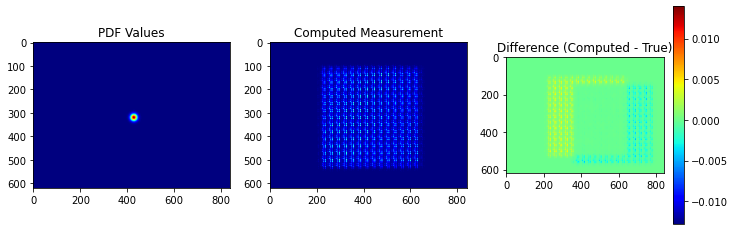

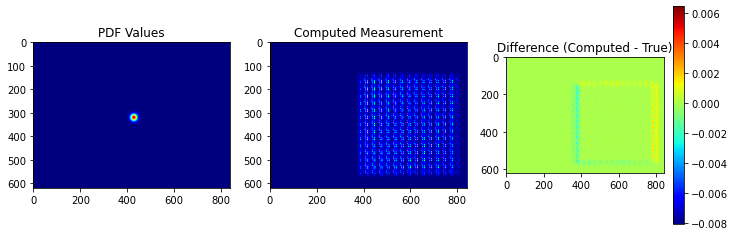

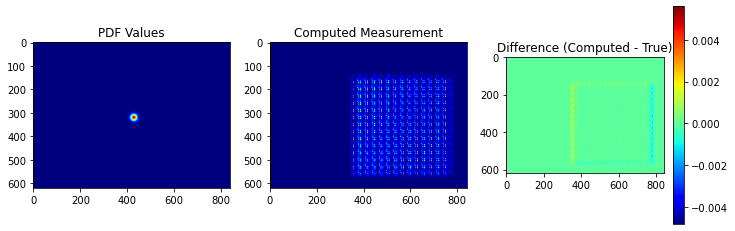

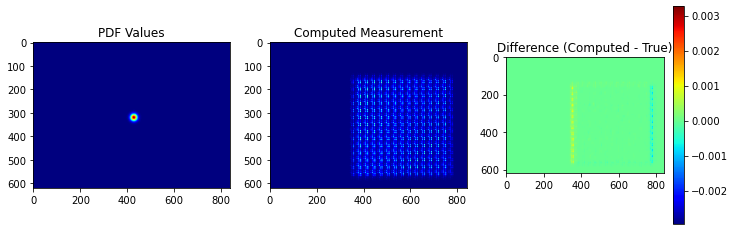

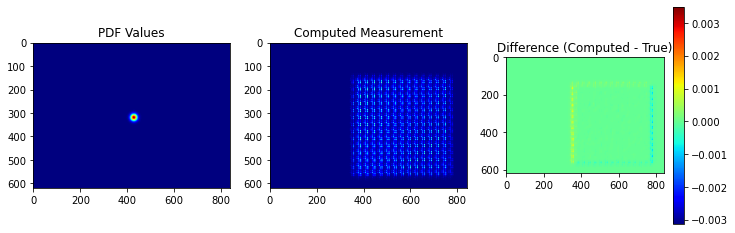

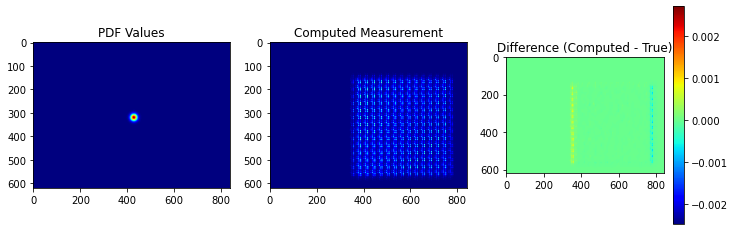

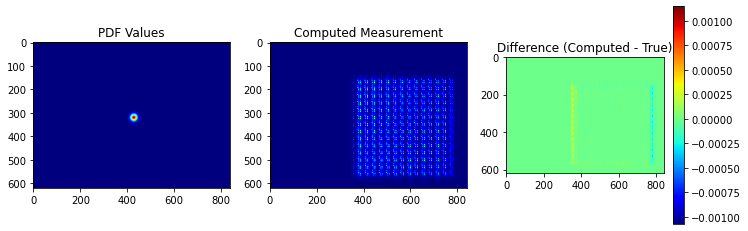

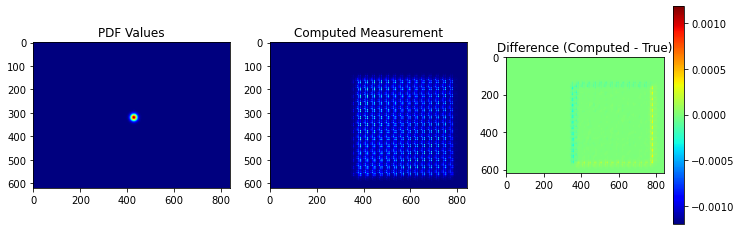

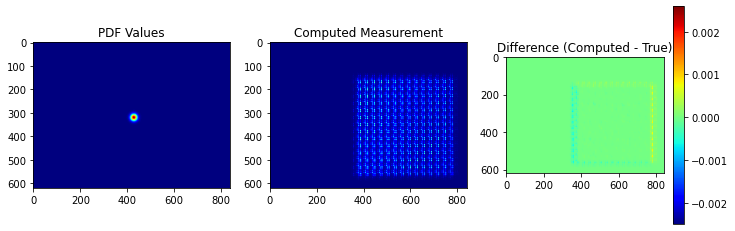

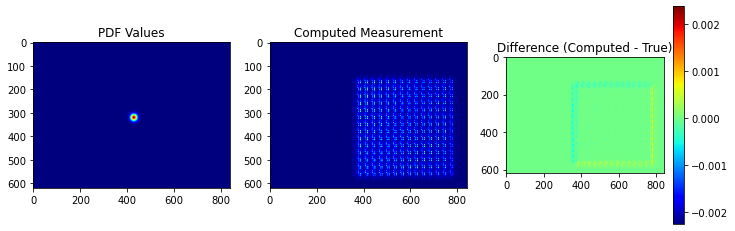

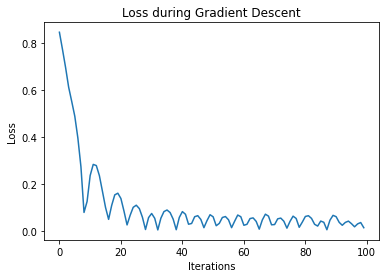

In [150]:
# Set number of iterations and initialize the loss tracker
# Need to rerun initialize random gaussian guess cells every time **
max_iters = 100
thresh = 1e-6
loss_GD = []

# Optimization loop
for i in range(max_iters):
    # Compute forward model using the current Gaussian parameters
    computed_measurement = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
    computed_measurement = computed_measurement / torch.norm(computed_measurement) # normalize
    
    # Compute PDF values based on the Gaussian parameters
    computed_values = g_init.computeValues(coords, NY, NX)
    
    # Plot the results every 10 iterations (optional)
    if i % 10 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(computed_values.detach().cpu().numpy(), cmap='jet')
        plt.title("PDF Values")

        plt.subplot(1, 3, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Computed Measurement")

        plt.subplot(1, 3, 3)
        plt.imshow((computed_measurement - gt_measurement).detach().cpu().numpy(), cmap='jet')
        plt.title("Difference (Computed - True)")
        plt.colorbar()
        
        plt.show()
    
    # Compute the loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - gt_measurement)
    loss_GD.append(loss.item())
    if i > 0: # stop if loss isn't changing
        if np.abs(loss_GD[i] - loss_GD[i-1]) < thresh:
            break
    
    # Perform a gradient step to update Gaussian parameters
    loss.backward()
    g_init.gradStep()
    
    # Zero the gradients after the update
    g_init.zeroGrad()

# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()

## Debugging

### Compare sdc vs. gaussplat measurements
Generally useful as we make updates to the forward models

In [184]:
# Gaussian parameters -- must be floats
muy = 50.0
mux = 150.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

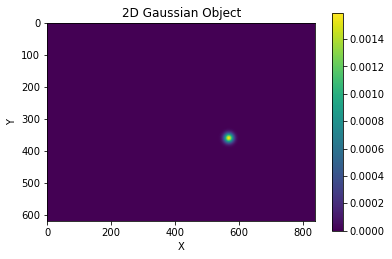

In [185]:
# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d_test = g_test.createPixelGauss(NY,NX,NL)
g_test.plot(coords, NY, NX)

In [186]:
# Pixel forward model

# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_test_padded = sdc.pad(g3d_test.detach())

# Get measurement
g3_test_measurement = sdc.forwardmodel3d(g3d_test_padded, hf_padded_3d, m)
g3_test_measurement = g3_test_measurement/torch.norm(g3_test_measurement) # normalize

In [187]:
# Gaussian forward model

# Get measurement
g_test_measurement = gp.forwardSingleGauss(g_test, NX, NY, NL, h, m)
g_test_measurement = g_test_measurement/torch.norm(g_test_measurement)

In [188]:
# Get difference
g_test_diff = g3_test_measurement - g_test_measurement
mse = torch.norm(g_test_diff)

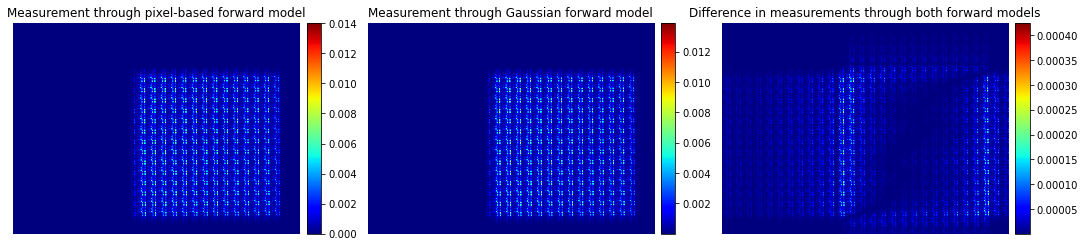

MSE:  0.018344340993110563


In [192]:
# Plot difference and get MSE

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust `figsize` as needed for better visuals

im1 = axes[0].imshow(g3_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g3_test_measurement.min().item(), 
                     vmax=g3_test_measurement.max().item())
axes[0].set_title("Measurement through pixel-based forward model")
axes[0].axis('off')
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)  # Adjust size and pad for appearance
fig.colorbar(im1, cax=cax1)

im2 = axes[1].imshow(g_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g_test_measurement.min().item(), 
                     vmax=g_test_measurement.max().item())
axes[1].set_title("Measurement through Gaussian forward model")
axes[1].axis('off')
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im2, cax=cax2)

im3 = axes[2].imshow(np.abs(g_test_diff.detach().numpy()), cmap='jet', 
                     vmin=np.abs(g_test_diff.detach().numpy()).min().item(), 
                     vmax=np.abs(g_test_diff.detach().numpy()).max().item())
axes[2].set_title("Difference in measurements through both forward models")
axes[2].axis('off')
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im3, cax=cax3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print("MSE: ", mse.detach().numpy())

### Wavelength

In [121]:
# 3D Gaussian
muy = 50.0
mux = 150.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3_test = g_test.createPixelGauss(NY,NX,NL)

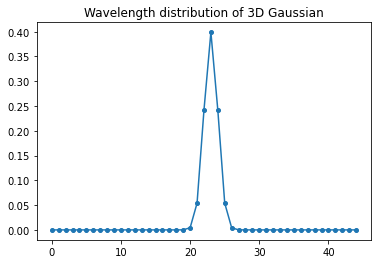

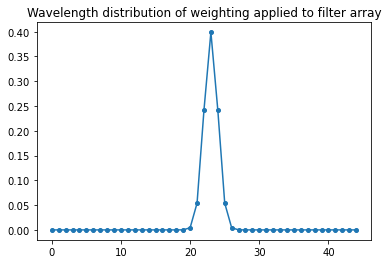

In [122]:
# Plot wavelength distributions

# 3D Gaussian
g3_wavelength_proj = g3d.sum(dim=(0,1)).detach()
plt.plot(g3_wavelength_proj, marker='o', markersize=4)
plt.title("Wavelength distribution of 3D Gaussian")
plt.show()

# Wavelength filter
_, gaus_lam = gp.createWVFilt(mul, sigl, NL, m)
plt.plot(gaus_lam, marker='o', markersize=4)
plt.title("Wavelength distribution of weighting applied to filter array")
plt.show()

### Check phasor

In [193]:
# 3D Gaussian
muy = 50.0
mux = 150.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)

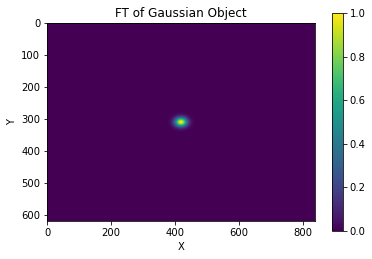

In [199]:
gauss_f_values_test = gp.createGaussFilter(g_test.covariancematrix, coords, NX, NY, g_test.amplitude)
phasor_test, phaseramp_test = gp.createPhasor(x,y,g_test.mux,g_test.muy)
gauss_f_test = gauss_f_values_test * phasor_test

plt.figure()
plt.imshow(torch.abs(gauss_f_test.detach()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FT of Gaussian Object')
plt.colorbar()
plt.show()

In [201]:
gauss_f_test_ifft = torch.fft.fftshift(torch.fft.ifft2(gauss_f_test,dim=(0,1)))
gauss_f_test_ifft = gauss_f_test_ifft/torch.amax(torch.abs(gauss_f_test_ifft))

